In [1]:

import pybedtools
pybedtools.set_bedtools_path('/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/bin/')
from pybedtools import BedTool
import pandas as pd
import numpy as np
from scipy.stats import chisquare

import os
from pathlib import Path
import sys
data_dir = Path('/tscc/nfs/home/hsher/projects/oligo_results/Final_published_figures')
sys.path.append(str(data_dir))

from plot_params import *


# load all splicing data
regions_dict = {}
for group in ['in', 'ex', 'ctrl']:
    regions = []
    # (ce, ue, de, fiu, fid)
    for region in ['casette', 'exon5', 'exon3', 'intron5_to_casette', 'intron3_to_casette']:
    
        bedfile = BedTool(data_dir/f'data/rbfox2_splicing_data/HEK293T.{group}.{region}.bed')
        
        regions_dict[group, region] = bedfile

In [2]:
# find peaks
basedir = Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS')
basedir2 = Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/DMM/finemapping/mapped_sites/CITS')

In [3]:
peak = BedTool(basedir/'HEK293_rep1.RBFOX2.finemapped_windows.bed.gz')

In [4]:
peak2 = BedTool(basedir2/'HEK293_rep1.RBFOX2.finemapped_windows.bed.gz')

In [5]:
data = []
for peak_file in basedir.glob("HEK*RBFOX2*.bed.gz"):
    peak = BedTool(peak_file)
    print(peak_file)
    libname = peak_file.name.split('.')[0]
    
    for key in regions_dict:
        region_bed = regions_dict[key]
        group, region = key
        
        n_region_has_peak = len(region_bed.intersect(peak, s = True, F = 0.5, u = True))
        n_region_no_peak = len(region_bed.intersect(peak, s = True, F = 0.5, v = True))
        
        data.append([libname, group, region, n_region_has_peak, n_region_no_peak])
data = pd.DataFrame(data, columns = ['libname', 'group', 'region', 'bound', 'not_bound'])

/tscc/nfs/home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS/HEK293_rep2.RBFOX2.finemapped_windows.bed.gz
/tscc/nfs/home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS/HEK293_rep1.RBFOX2.finemapped_windows.bed.gz


dmm_data

In [6]:
dmm_data = []
for peak_file in basedir2.glob("HEK*RBFOX2*.bed.gz"):
    peak = BedTool(peak_file)
    print(peak_file)
    libname = peak_file.name.split('.')[0]
    
    for key in regions_dict:
        region_bed = regions_dict[key]
        group, region = key
        
        n_region_has_peak = len(region_bed.intersect(peak, s = True, F = 0.5, u = True))
        n_region_no_peak = len(region_bed.intersect(peak, s = True, F = 0.5, v = True))
        
        dmm_data.append([libname, group, region, n_region_has_peak, n_region_no_peak])
dmm_data = pd.DataFrame(dmm_data, columns = ['libname', 'group', 'region', 'bound', 'not_bound'])

/tscc/nfs/home/hsher/scratch/ABC_2rep/DMM/finemapping/mapped_sites/CITS/HEK293_rep2.RBFOX2.finemapped_windows.bed.gz
/tscc/nfs/home/hsher/scratch/ABC_2rep/DMM/finemapping/mapped_sites/CITS/HEK293_rep1.RBFOX2.finemapped_windows.bed.gz


In [7]:
dmmpeak = BedTool('/tscc/nfs/home/hsher/scratch/ABC_2rep/DMM/finemapping/mapped_sites/CITS/HEK293_rep1.RBFOX2.finemapped_windows.bed.gz')
dmm_region = {}
for key in regions_dict:
    region_bed = regions_dict[key]
    
    dmm_region[key] = region_bed.intersect(dmmpeak, s = True, F = 0.5, u = True).saveas()

In [8]:
import pysam
from Bio.Seq import Seq
def getRNAsequence(interval):
    ''' fetch RNA sequence from bedtool interval'''
    fasta = pysam.FastaFile('/tscc/nfs/home/hsher/gencode_coords/GRCh38.primary_assembly.genome.fa')
    seq = fasta.fetch(reference = interval.chrom, start=interval.start, end=interval.stop)
    
    if interval.strand == '-':
        
        seq = Seq(seq).reverse_complement().transcribe()
    
    else:
        seq = Seq(seq).transcribe()
    
    return seq

In [9]:

dmm_seqcontent = []
for r in dmm_region:
    bed = dmm_region[r]
    
    dmm_seqcontent = [str(getRNAsequence(i)) for i in bed]
    fr_motif = ['GCAUG' in s for s in dmm_seqcontent]
    print(r, np.mean(fr_motif), len(fr_motif))

('in', 'casette') 0.5 4
('in', 'exon5') 1.0 3
('in', 'exon3') 1.0 6
('in', 'intron5_to_casette') 0.9 10
('in', 'intron3_to_casette') 0.6666666666666666 3
('ex', 'casette') 0.125 8
('ex', 'exon5') 1.0 5
('ex', 'exon3') 0.8571428571428571 7
('ex', 'intron5_to_casette') 0.1111111111111111 9
('ex', 'intron3_to_casette') 0.56 25
('ctrl', 'casette') 0.42857142857142855 7
('ctrl', 'exon5') 0.8 10
('ctrl', 'exon3') 0.85 20
('ctrl', 'intron5_to_casette') 0.42857142857142855 7
('ctrl', 'intron3_to_casette') 0.4166666666666667 12


In [10]:
clipper_data = []
clipper_files = Path('/tscc/projects/ps-yeolab5/ABC_chisq_peaks/').glob('Dan_multiplex1_HEK*/*RBFOX2*compressed.bed')
for peak_file in clipper_files:
    peak = BedTool(peak_file).filter(lambda x: float(x[3])>3 and float(x[4])>3).saveas()
    libname = str(peak_file).split('/')[-2].replace('Dan_multiplex1_', '')
    
    for key in regions_dict:
        region_bed = regions_dict[key]
        group, region = key
        
        n_region_has_peak = len(region_bed.intersect(peak, s = True, F = 0.5, u = True))
        n_region_no_peak = len(region_bed.intersect(peak, s = True, F = 0.5, v = True))
        
        clipper_data.append([libname, group, region, n_region_has_peak, n_region_no_peak])
clipper_data = pd.DataFrame(clipper_data, columns = ['libname', 'group', 'region', 'bound', 'not_bound'])

In [11]:
col = ['libname', 'group', 'region']
all_counts = clipper_data.merge(data, left_on = col, right_on = col, suffixes = ('_clipper', '_beta-binom_mixture'))
all_counts = all_counts.merge(dmm_data, left_on = col, right_on = col)
all_counts.rename({'bound':'bound_dmm', 'not_bound':'not_bound_dmm'}, axis = 1, inplace = True)

In [12]:
all_counts.head()

,libname,group,region,bound_clipper,not_bound_clipper,bound_beta-binom_mixture,not_bound_beta-binom_mixture,bound_dmm,not_bound_dmm
0,HEK293_rep2,in,casette,6,144,3,147,4,146
1,HEK293_rep2,in,exon5,1,149,2,148,5,145
2,HEK293_rep2,in,exon3,2,148,4,146,5,145
3,HEK293_rep2,in,intron5_to_casette,5,141,11,135,14,132
4,HEK293_rep2,in,intron3_to_casette,3,143,5,141,5,141


In [13]:
reg_order = ['exon5', 'intron5_to_casette', 'casette', 'intron3_to_casette', 'exon3']

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


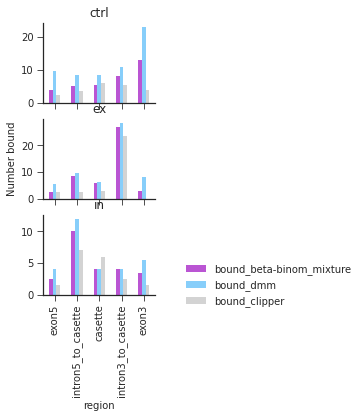

In [14]:
f, ax = plt.subplots(3,1, figsize =(2,5), sharey = False, sharex = True)
i = 0
for name, group in all_counts.groupby(by = 'group'):
    group.groupby(by = ['region']).mean(
    ).loc[reg_order, ['bound_beta-binom_mixture', 'bound_dmm', 'bound_clipper']].plot.bar(
        ax = ax[i], legend = False, color = ['mediumorchid', 'lightskyblue', 'lightgrey']
    )
    ax[i].set_title(name)
    if i == 1:
        ax[i].set_ylabel('Number bound')
    i+=1
sns.despine()
ax[i-1].legend(bbox_to_anchor = (1.2, 0.5))
plt.tight_layout()
plt.savefig(figdir/'RBFOX2_splicing_number.pdf')

In [15]:
group

,libname,group,region,bound_clipper,not_bound_clipper,bound_beta-binom_mixture,not_bound_beta-binom_mixture,bound_dmm,not_bound_dmm
0,HEK293_rep2,in,casette,6,144,3,147,4,146
1,HEK293_rep2,in,exon5,1,149,2,148,5,145
2,HEK293_rep2,in,exon3,2,148,4,146,5,145
3,HEK293_rep2,in,intron5_to_casette,5,141,11,135,14,132
4,HEK293_rep2,in,intron3_to_casette,3,143,5,141,5,141
15,HEK293_rep1,in,casette,6,144,5,145,4,146
16,HEK293_rep1,in,exon5,2,148,3,147,3,147
17,HEK293_rep1,in,exon3,1,149,3,147,6,144
18,HEK293_rep1,in,intron5_to_casette,9,137,9,137,10,136
19,HEK293_rep1,in,intron3_to_casette,2,144,3,143,3,143


In [16]:
from scipy.stats import fisher_exact
from scipy.stats import chisquare
from statsmodels.stats.multitest import fdrcorrection
def counts_to_stat(data):
    stats = []
    pseudocount = 1
    for name, group in data.groupby(by = ['libname', 'region']):
        
        ctrl = group.loc[group['group']=='ctrl', ['bound', 'not_bound']].values
        
        for direction in ['in', 'ex']:
            change = group.loc[group['group']==direction, ['bound', 'not_bound']].values


            pv = np.concatenate([change, ctrl], axis = 0)
            if np.any(pv<=5):
                odds_ratio, pval = fisher_exact(pv+pseudocount, alternative = 'greater')
            else:
                chi, pval = chisquare(change[0], ctrl[0]/(ctrl[0].sum()/change[0].sum()))
                odds_ratio = (change[0,0]/change[0,1])/(ctrl[0,0]/ctrl[0,1])

                

            stats.append([name[0], name[1], direction, odds_ratio, pval])
    stats = pd.DataFrame(stats, columns = ['libname', 'region', 'direction', 'odds', 'pval'])
    _, stats['FDR'] = fdrcorrection(stats['pval'])
    stats['asterstick'] = stats['FDR'].apply(lambda p: '***' if p<1e-10
                                                       else '**' if p<0.001 else
                                                      '*' if p<0.05 else '')
    return stats

In [17]:
clipper_stat = counts_to_stat(clipper_data)
stripper_stat = counts_to_stat(data)
dmm_stat = counts_to_stat(dmm_data)

In [18]:
clipper_stat['method'] = 'CLIPper+CC'
stripper_stat['method'] = 'BBM'
dmm_stat['method'] = 'DMM'

In [19]:
stats = pd.concat([clipper_stat, stripper_stat, dmm_stat])

In [31]:
group

,libname,direction,odds,pval,FDR,asterstick,method
region,,,,,,,
exon5,HEK293_rep1,in,10.046980,1.240764e-02,2.255934e-02,*,CLIPper+CC
exon5,HEK293_rep2,in,4.986667,9.859146e-02,1.159900e-01,,CLIPper+CC
exon5,HEK293_rep1,in,8.081081,6.012397e-03,1.002066e-02,*,BBM
exon5,HEK293_rep2,in,6.020134,3.026113e-02,3.782641e-02,*,BBM
exon5,HEK293_rep1,in,3.658477,4.207058e-02,4.674509e-02,*,DMM
exon5,HEK293_rep2,in,6.123288,2.021716e-03,3.675847e-03,*,DMM
intron5_to_casette,HEK293_rep1,in,21.434783,5.691804e-08,3.577616e-07,**,CLIPper+CC
intron5_to_casette,HEK293_rep2,in,15.633803,7.797936e-05,2.599312e-04,**,CLIPper+CC
intron5_to_casette,HEK293_rep1,in,21.434783,5.691804e-08,2.276721e-07,**,BBM


In [34]:
pv

method                     BBM              CLIPper+CC              \
libname            HEK293_rep1 HEK293_rep2 HEK293_rep1 HEK293_rep2   
region                                                               
casette              15.369863    4.477477    6.893519   18.055172   
exon3                 3.355856    3.159014    3.992000    6.028188   
exon5                 8.081081    6.020134   10.046980    4.986667   
intron3_to_casette    3.704545    8.879276    3.801724    8.183333   
intron5_to_casette   21.434783   20.044444   21.434783   15.633803   

method                     DMM              
libname            HEK293_rep1 HEK293_rep2  
region                                      
casette               6.343537    4.604205  
exon3                 3.083333    2.245053  
exon5                 3.658477    6.123288  
intron3_to_casette    3.130342    5.635083  
intron5_to_casette   15.493697   15.612121

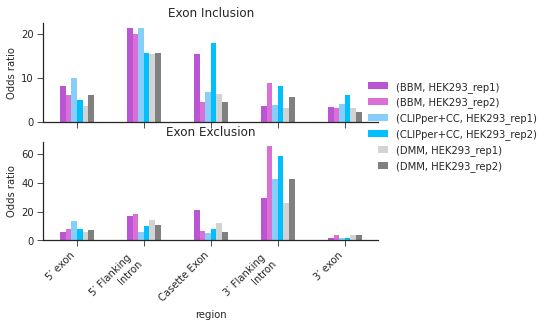

In [35]:
name_dict = {'in': 'Exon Inclusion',
             'ex': 'Exon Exclusion'}

region_rename = {'casette': 'Casette Exon', 
                  'exon3': '3′ exon', 
                  'exon5': '5′ exon', 
                  'intron3_to_casette': '3′ Flanking \nIntron',
                   'intron5_to_casette': '5′ Flanking \nIntron'
                }
f, ax = plt.subplots(2,1, sharex = True, sharey = False)
ax = ax.flatten(order = 'F')[::-1]
i = 0
for name, group in stats.groupby(by = ['direction']):
    group.set_index('region', inplace = True)
    group = group.loc[reg_order]
    
    #group.loc[reg_order, 'odds'].plot.bar(ax = ax[i])
    pv = pd.pivot_table(group, columns = 'region', index = ['method', 'libname'], values = 'odds').T
    pv.loc[reg_order].rename(region_rename, axis = 0).plot.bar(
    color = ['mediumorchid', 'orchid', 'lightskyblue', 'deepskyblue', 'lightgrey', 'grey'], ax = ax[i], legend = False)
    
    aster = pd.pivot_table(group, columns = 'region', index = ['method', 'libname'], values = 'asterstick', aggfunc = lambda x:x).T
    # for x, reg in enumerate(reg_order):
    #     odds = pv.loc[reg]
    #     ast = aster.loc[reg]
    #     for yi, y in enumerate(odds):
            
    #         ax[i].text(x-0.2+yi/8, max(y*1.1, y+5), ast[yi],rotation = 'vertical')
    ax[i].set_title(name_dict[name])
    ax[i].set_ylabel('Odds ratio')
    
    i += 1
ax[i-1].legend(bbox_to_anchor = (1.5,0.5))
plt.xticks(rotation=45, ha='right')

sns.despine()
plt.savefig(figdir/'RBFOX2_splicing_odds.pdf')

In [23]:
pv

method                     BBM              CLIPper+CC              \
libname            HEK293_rep1 HEK293_rep2 HEK293_rep1 HEK293_rep2   
region                                                               
casette              15.369863    4.477477    6.893519   18.055172   
exon3                 3.355856    3.159014    3.992000    6.028188   
exon5                 8.081081    6.020134   10.046980    4.986667   
intron3_to_casette    3.704545    8.879276    3.801724    8.183333   
intron5_to_casette   21.434783   20.044444   21.434783   15.633803   

method                     DMM              
libname            HEK293_rep1 HEK293_rep2  
region                                      
casette               6.343537    4.604205  
exon3                 3.083333    2.245053  
exon5                 3.658477    6.123288  
intron3_to_casette    3.130342    5.635083  
intron5_to_casette   15.493697   15.612121

In [24]:
aster

method                     BBM              CLIPper+CC              \
libname            HEK293_rep1 HEK293_rep2 HEK293_rep1 HEK293_rep2   
region                                                               
casette                     **           *          **          **   
exon3                                    *                       *   
exon5                        *           *           *               
intron3_to_casette           *           *                       *   
intron5_to_casette          **         ***          **          **   

method                     DMM              
libname            HEK293_rep1 HEK293_rep2  
region                                      
casette                      *           *  
exon3                        *              
exon5                        *           *  
intron3_to_casette                       *  
intron5_to_casette         ***         ***